In [1]:
import torch
import os
import numpy as np
import scipy.misc as m
import imageio as im
from PIL import Image, ImageColor
from torch.utils import data
from torch.utils.data import DataLoader
import torch.nn as nn
from skimage.transform import rescale, resize, downscale_local_mean
import sklearn.metrics as skm
import torch.optim as optim
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt  
import torch.nn.functional as F
import time
import cv2

In [2]:
 import torch
 torch.cuda.empty_cache()

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
import glob

dir_file = '/content/drive/My Drive/a2d2'

dir_files = os.listdir(dir_file)
print(dir_files)

['class_list.json', 'lidar', 'label', 'camera']


In [5]:
cam_file_val = '/content/drive/My Drive/a2d2/camera/cam_front_center/val'
label_file_val = '/content/drive/My Drive/a2d2/label/cam_front_center/val'
cam_file_train = '/content/drive/My Drive/a2d2/camera/cam_front_center/train'
label_file_train = '/content/drive/My Drive/a2d2/label/cam_front_center/train'
cam_file_test = '/content/drive/My Drive/a2d2/camera/cam_front_center/test'
label_file_test = '/content/drive/My Drive/a2d2/label/cam_front_center/test'


cam_files_val = []
label_files_val = []
cam_files_test = []
label_files_test = []
cam_files_train = []
label_files_train = []

for file in os.listdir(label_file_val):
   if file.endswith(".png"):
     label_files_val.append(file)

for file in os.listdir(cam_file_val):
   if file.endswith(".png"):
     cam_files_val.append(file)

for file in os.listdir(label_file_test):
   if file.endswith(".png"):
     label_files_test.append(file)

for file in os.listdir(cam_file_test):
   if file.endswith(".png"):
     cam_files_test.append(file)

for file in os.listdir(label_file_train):
   if file.endswith(".png"):
     label_files_train.append(file)

for file in os.listdir(cam_file_train):
   if file.endswith(".png"):
     cam_files_train.append(file)

cam_files_val.sort()
label_files_val.sort()

cam_files_test.sort()
label_files_test.sort()

cam_files_train.sort()
label_files_train.sort()

print(cam_files_val)
print(label_files_val)
print("cam files val",len(cam_files_val))
print("label files val",len(label_files_val))

print(cam_files_test)
print(label_files_test)
print("cam files test",len(cam_files_test))
print("label files test",len(label_files_test))

print(cam_files_train)
print(label_files_train)
print("cam files train",len(cam_files_train))
print("label files train",len(label_files_train))

['20181204170238_camera_frontcenter_000000330.png', '20181204170238_camera_frontcenter_000000582.png', '20181204170238_camera_frontcenter_000001280.png', '20181204170238_camera_frontcenter_000001867.png', '20181204170238_camera_frontcenter_000003718.png', '20181204170238_camera_frontcenter_000004087.png', '20181204170238_camera_frontcenter_000004110.png', '20181204170238_camera_frontcenter_000004425.png', '20181204170238_camera_frontcenter_000004467.png', '20181204170238_camera_frontcenter_000005400.png', '20181204170238_camera_frontcenter_000005707.png', '20181204170238_camera_frontcenter_000006231.png', '20181204170238_camera_frontcenter_000006240.png', '20181204170238_camera_frontcenter_000006297.png', '20181204170238_camera_frontcenter_000006592.png', '20181204170238_camera_frontcenter_000006660.png', '20181204170238_camera_frontcenter_000006949.png', '20181204170238_camera_frontcenter_000006966.png', '20181204170238_camera_frontcenter_000007335.png', '20181204170238_camera_frontce

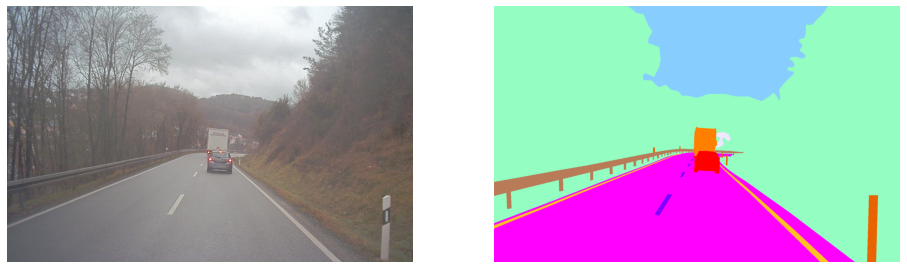

In [6]:
from google.colab.patches import cv2_imshow
img = cv2.imread(cam_file_train + '/' + cam_files_train[22])
# cv2_imshow(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gt_img = cv2.imread(label_file_train + '/' + label_files_train[22])
# cv2_imshow(gt_img)
gt_img = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)


plt.figure(figsize=(16, 8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(gt_img)
plt.axis('off')
plt.show()

In [7]:
path_data = "/content/drive/My Drive/a2d2"

list_dir = []

learning_rate = 1e-6
train_epochs = 10
n_classes = 4
batch_size = 2
num_workers = 2

list_dir = os.listdir(path_data)
print(list_dir)

['class_list.json', 'lidar', 'label', 'camera']


In [8]:
def recursive_glob(rootdir=".", suffix=""):
    return [
        os.path.join(looproot, filename)
        for looproot, _, filenames in os.walk(rootdir)
        for filename in filenames
        if filename.endswith(suffix)
    ]


In [10]:
class A2D2Loader(data.Dataset):
    colors =[
        [255,  255, 255],     
        [255,193, 37],
        [128, 0,255],
        [255, 0,255],
    ]
    n_classes=4
    label_colours = dict(zip(range(n_classes), colors))

    def __init__(
        self,
        root,
        split="train",
        is_transform=True,
        img_size=(512, 256)
    ):
        self.root = root
        self.split = split
        self.is_transform = is_transform
        self.n_classes = 4
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.files = {}

        # makes it: /content/drive/My Drive/a2d2/20181108_091945 + /camera/cam_front_center/ + train (as we named the split folder this)
        self.images_base = os.path.join(self.root, "camera/cam_front_center", self.split)
        self.annotations_base = os.path.join(self.root, "label/cam_front_center", self.split)
        
        # contains list of all pngs inside all different folders. Recursively iterates 
        self.files[split] = recursive_glob(rootdir=self.images_base, suffix=".png")

        #  так лучше было не делать, кажется 
        self.void_classes =  [11, 26, 38, 43, 45, 46, 48, 52, 56, 60, 62, 75, 76, 86, 88, 91, 97, 104, 107, 112, 113, 117, 120, 128, 133, 135, 137, 138, 145, 146, 150, 151, 156, 157, 163, 165, 167, 179, 180, 186, 190, 215, 226, 228, 230, 236, 237, 249]
        
        self.valid_classes = [255, 194, 67, 105]
        
        
        self.class_names = [
            "unlabelled",
            "Solid line",
            "Dashed line",
            "RD normal street",
        ]
        
        # for void_classes; useful for loss function
        self.ignore_index = 255
        
        self.class_map = dict(zip(self.valid_classes, range(self.n_classes)))

        if not self.files[split]:
            raise Exception("No files for split=[%s] found in %s" % (split, self.images_base))
        
        # prints number of images found
        print("Found %d %s images" % (len(self.files[split]), split))

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        # path of image
        img_path = self.files[self.split][index].rstrip()
        # path of label
        lbl_path = os.path.join(
            self.annotations_base,
            os.path.basename(img_path)[:14] + "_label_" + os.path.basename(img_path)[-25:],
        )
        # read image
        img = im.imread(img_path)
        # convert to numpy array
        img = np.array(img, dtype=np.uint8)

        # read label
        lbl = Image.open(lbl_path).convert('L')
        # encode using encode_segmap function: 0... and 250
        lbl = self.encode_segmap(np.array(lbl, dtype=np.uint8))

        if self.is_transform:
            img, lbl = self.transform(img, lbl)
        
        return img, lbl

    def transform(self, img, lbl):       
        # Image resize; I think imresize outputs in different format than what it received
        img =np.array(Image.fromarray(img).resize((self.img_size[0], self.img_size[1])))  # uint8 with RGB mode
        # change to BGR
        img = img[:, :, ::-1]  # RGB -> BGR
        # change data type to float64
        img = img.astype(np.float64)
        # subtract mean
        # NHWC -> NCHW
        img = img.transpose(2, 0, 1)

        
        classes = np.unique(lbl)
        lbl = lbl.astype(float)
        lbl = np.array(Image.fromarray(lbl).resize((self.img_size[0], self.img_size[1]), resample = Image.NEAREST))
        lbl = lbl.astype(int)

        if not np.all(classes == np.unique(lbl)):
            print("WARN: resizing labels yielded fewer classes")

        if not np.all(np.unique(lbl[lbl != self.ignore_index]) < self.n_classes):
            print("after det", classes, np.unique(lbl))
            raise ValueError("Segmentation map contained invalid class values")

        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()

        return img, lbl
      
    def decode_segmap(self, temp):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, self.n_classes):
            r[temp == l] = self.label_colours[l][0]
            g[temp == l] = self.label_colours[l][1]
            b[temp == l] = self.label_colours[l][2]

        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb


    def encode_segmap(self, mask):

        for _voidc in self.void_classes:
            mask[mask == _voidc] = self.ignore_index
        for _validc in self.valid_classes:
            mask[mask == _validc] = self.class_map[_validc]
        return mask

In [11]:
path_data = "/content/drive/My Drive/a2d2/"

train_data = A2D2Loader(
    root = path_data, 
    split='train'
    )

val_data = A2D2Loader(
    root = path_data, 
    split='val'
    )

test_data = A2D2Loader(
    root = path_data, 
    split='test'
    )

train_loader = DataLoader(
    train_data,
    batch_size = batch_size,
    shuffle=True,
    num_workers = num_workers,
)

val_loader = DataLoader(
    val_data,
    batch_size = batch_size,
    num_workers = num_workers,
)

test_loader = DataLoader(
    test_data,
    batch_size = batch_size,
    num_workers = num_workers,
)

print(type(train_data))
print(type(train_loader))

Found 1196 train images
Found 100 val images
Found 44 test images
<class '__main__.A2D2Loader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [12]:
class Up_Sample_Conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(Up_Sample_Conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2), # Nearest neighbour for upsampling are two 
            nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

    
class Repeat(nn.Module):
    def __init__(self, ch_out):
        super(Repeat, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)) 

    def forward(self, x):
        for i in range(2):
            if i == 0:
                x_rec = self.conv(x)
            x_rec = self.conv(x + x_rec)
        return x_rec

class RR_Conv(nn.Module):
    def __init__(self, ch_in, ch_out):
        super(RR_Conv, self).__init__()
        self.Repeat_block = nn.Sequential(Repeat(ch_out),Repeat(ch_out))
        self.Conv = nn.Conv2d(ch_in, ch_out, 1, 1, 0)

    def forward(self, input_img):
        input_img = self.Conv(input_img)
        conv_input_img = self.Repeat_block(input_img)
        return input_img + conv_input_img 
    
############
############

class R2U_Net(nn.Module):
#output_ch=n_classes
    def __init__(self, img_ch=3, output_ch=4):
        super(R2U_Net, self).__init__()
        
        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.channel_1 = 64 
        self.channel_2 = 2*self.channel_1
        self.channel_3 = 2*self.channel_2
        self.channel_4 = 2*self.channel_3
        self.channel_5 = 2*self.channel_4
        
        # For new layer added
        self.channel_6 = 2*self.channel_5
        
        self.channels = [self.channel_1, self.channel_2, self.channel_3, self.channel_4, self.channel_5, self.channel_6]
            
 
        self.Layer1 = RR_Conv(img_ch, self.channels[0])
        self.Layer2 = RR_Conv(self.channels[0], self.channels[1])
        self.Layer3 = RR_Conv(self.channels[1], self.channels[2])
        self.Layer4 = RR_Conv(self.channels[2], self.channels[3])
        self.Layer5 = RR_Conv(self.channels[3], self.channels[4])
        self.Layer6 = RR_Conv(self.channels[4], self.channels[5]) 

        self.DeConvLayer6 = Up_Sample_Conv(self.channels[5], self.channels[4]) 
        self.DeConvLayer5 = Up_Sample_Conv(self.channels[4], self.channels[3])
        self.DeConvLayer4 = Up_Sample_Conv(self.channels[3],self.channels[2])
        self.DeConvLayer3 = Up_Sample_Conv(self.channels[2], self.channels[1])
        self.DeConvLayer2 = Up_Sample_Conv(self.channels[1], self.channels[0])
        
        self.Up_Layer6 = RR_Conv(self.channels[5], self.channels[4]) 
        self.Up_Layer5 = RR_Conv(self.channels[4], self.channels[3])
        self.Up_Layer4 = RR_Conv(self.channels[3], self.channels[2])
        self.Up_Layer3 = RR_Conv(self.channels[2], self.channels[1])
        self.Up_Layer2 = RR_Conv(self.channels[1], self.channels[0])
        
        self.Conv = nn.Conv2d(self.channels[0], output_ch, kernel_size=1, stride=1, padding=0)        
        
    def forward(self, x):
        conv1 = self.Layer1(x)
        mp1 = self.MaxPool(conv1)
        conv2 = self.Layer2(mp1)
        mp2 = self.MaxPool(conv2)
        conv3 = self.Layer3(mp2)
        mp3 = self.MaxPool(conv3)
        conv4 = self.Layer4(mp3)
        mp4 = self.MaxPool(conv4)
        conv5 = self.Layer5(mp4)
        mp5 = self.MaxPool(conv5)
        conv6 = self.Layer6(mp5)

        deconv6 = self.DeConvLayer6(conv6)
        deconv6 = torch.cat((conv5, deconv6), dim=1)
        deconv6 = self.Up_Layer6(deconv6)

        
        deconv5 = self.DeConvLayer5(deconv6)
        deconv5 = torch.cat((conv4, deconv5), dim=1)
        deconv5 = self.Up_Layer5(deconv5)
        deconv4 = self.DeConvLayer4(deconv5)
        deconv4 = torch.cat((conv3, deconv4), dim=1)
        deconv4 = self.Up_Layer4(deconv4)
        deconv3 = self.DeConvLayer3(deconv4)
        deconv3 = torch.cat((conv2, deconv3), dim=1)
        deconv3 = self.Up_Layer3(deconv3)
        deconv2 = self.DeConvLayer2(deconv3)
        deconv2 = torch.cat((conv1, deconv2), dim=1)
        deconv2 = self.Up_Layer2(deconv2)
        deconv1 = self.Conv(deconv2)

        return deconv1

In [13]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.8.2
Hub version: 0.12.0
GPU is available


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = R2U_Net().to(device)

In [15]:
model.load_state_dict(torch.load("/content/drive/My Drive/a2d2_13_06_22.h5"))
model.eval()

R2U_Net(
  (MaxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Layer1): RR_Conv(
    (Repeat_block): Sequential(
      (0): Repeat(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (1): Repeat(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
    )
    (Conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (Layer2): RR_Conv(
    (Repeat_block): Sequential(
      (0): Repeat(
        (conv): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, mom

In [16]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def cross_entropy2d(input, target, weight=None, reduction='mean'):
    n, c, h, w = input.size()
    nt, ht, wt = target.size()

    if h != ht and w != wt:  # upsample labels
        input = F.interpolate(input, size=(ht, wt), mode="bilinear", align_corners=True)

    input = input.transpose(1, 2).transpose(2, 3).contiguous().view(-1, c)
    target = target.view(-1)
    loss = F.cross_entropy(
        input, target, weight=weight, reduction=reduction, ignore_index=255
    )
    return loss

In [17]:
def get_metrics(gt_label, pred_label):
    #Accuracy Score
    acc = skm.accuracy_score(gt_label, pred_label, normalize=True)
    
    #Jaccard Score/IoU
    js = skm.jaccard_score(gt_label, pred_label, average='micro')
    
    result_gm_sh = [acc, js]
    return(result_gm_sh)

class runningScore(object):
    def __init__(self, n_classes):
        self.n_classes = n_classes
        self.confusion_matrix = np.zeros((n_classes, n_classes))

    def _fast_hist(self, label_true, label_pred, n_class):
        mask = (label_true >= 0) & (label_true < n_class)
        hist = np.bincount(
            n_class * label_true[mask].astype(int) + label_pred[mask], minlength=n_class ** 2
        ).reshape(n_class, n_class)
        return hist

    def update(self, label_trues, label_preds):
        for lt, lp in zip(label_trues, label_preds):
            self.confusion_matrix += self._fast_hist(lt.flatten(), lp.flatten(), self.n_classes)

    def get_scores(self):
        # confusion matrix
        hist = self.confusion_matrix 

        TP = np.diag(hist)
        TN = hist.sum() - hist.sum(axis = 1) - hist.sum(axis = 0) + np.diag(hist)
        FP = hist.sum(axis = 1) - TP
        FN = hist.sum(axis = 0) - TP
        
        
        # Specificity: TN / TN + FP
        specif_cls = (TN) / (TN + FP + 1e-7)
        specif = np.nanmean(specif_cls)
        
        # Senstivity/Recall: TP / TP + FN
        sensti_cls = (TP) / (TP + FN + 1e-7)
        sensti = np.nanmean(sensti_cls)
        
        # Precision: TP / (TP + FP)
        prec_cls = (TP) / (TP + FP + 1e-7)
        prec = np.nanmean(prec_cls)
        
        # F1 = 2 * Precision * Recall / Precision + Recall
        f1 = (2 * prec * sensti) / (prec + sensti + 1e-7)
        
        return (
            {
                "Specificity": specif,
                "Senstivity": sensti,
                "F1": f1,
                "Precision": prec,
            }
        )

    def reset(self):
        self.confusion_matrix = np.zeros((self.n_classes, self.n_classes))

In [19]:
def train(train_loader, model, optimizer, epoch_i, epoch_total):
        count = 0
        
        # List to cumulate loss during iterations
        loss_list = []
        for (images, labels) in train_loader:
            count += 1
            
            # we used model.eval() below. This is to bring model back to training mood.
            model.train()

            images = images.to(device)
            labels = labels.to(device)
            
            # Model Prediction
            pred = model(images)
            
            # Loss Calculation
            loss = cross_entropy2d(pred, labels)
            loss_list.append(loss)

            # optimiser
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # interval to print train statistics
            if count % 50 == 0:
                fmt_str = "Image*batch: {:d} in epoch: [{:d}/{:d}]  and Loss: {:.4f}"
                print_str = fmt_str.format(
                    count,
                    epoch_i + 1,
                    epoch_total,
                    loss.item()
                )
                print(print_str)
                   
#           # break for testing purpose
#             if count == 10:
#                 break
        return(loss_list)

In [22]:
def validate(val_loader, model, epoch_i):
    
    # tldr: to make layers behave differently during inference (vs training)
    model.eval()
    running_metrics_val = runningScore(4)
    
    # empty list to add Accuracy and Jaccard Score Calculations
    acc_sh = []
    js_sh = []
    
    with torch.no_grad():
        for image_num, (val_images, val_labels) in tqdm(enumerate(val_loader)):
            
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)
            
            # Model prediction
            val_pred = model(val_images)
            
            pred = val_pred.data.max(1)[1].cpu().numpy()
            gt = val_labels.data.cpu().numpy()
            
            # Updating Mertics
            running_metrics_val.update(gt, pred)
            sh_metrics = get_metrics(gt.flatten(), pred.flatten())
            acc_sh.append(sh_metrics[0])
            js_sh.append(sh_metrics[1])

            val_pred = model(val_images)

            # Coverting val_pred from (1, 19, 512, 1024) to (1, 512, 1024)
            # considering predictions with highest scores for each pixel among 19 classes        
            prediction = val_pred.data.max(1)[1].cpu().numpy()
            ground_truth = val_labels.data.cpu().numpy()

            if image_num == 0:
            
            # Model Prediction
              decoded_pred = val_data.decode_segmap(prediction[0])
              plt.imshow(decoded_pred)
              plt.axis('off')
              plt.show()
              plt.clf()
            
            # Ground Truth
              decode_gt = val_data.decode_segmap(ground_truth[0])
              plt.imshow(decode_gt)
              plt.axis('off')
              plt.show()
                               
    score = running_metrics_val.get_scores()
    running_metrics_val.reset()
    
    acc_s = sum(acc_sh)/len(acc_sh)
    js_s = sum(js_sh)/len(js_sh)
    score["acc"] = acc_s
    score["js"] = js_s
    
    print("Different Metrics were: ", score)  
    return(score)

In [ ]:
if __name__ == "__main__":

    loss_all_epochs = []
    Specificity_ = []
    Senstivity_ = []
    F1_ = []
    acc_ = []
    js_ = []
    Precision = []
    t = []
    
    for epoch_i in range(train_epochs):
        # train
        print(f"Epoch {epoch_i + 1}\n-------------------------------")
        t1 = time.time()
        loss_i = train(train_loader, model, optimizer, epoch_i, train_epochs)
        loss_all_epochs.append(loss_i)
        t2 = time.time()
        print("It took: ", t2-t1, " unit time")

        # metrics 
        dummy_list = validate(val_loader, model, epoch_i)   
        
        # Add metrics to empty list
        t.append(t2-t1)
        Specificity_.append(dummy_list["Specificity"])
        Senstivity_.append(dummy_list["Senstivity"])
        F1_.append(dummy_list["F1"])
        acc_.append(dummy_list["acc"])
        js_.append(dummy_list["js"])
        Precision.append(dummy_list["Precision"])

Epoch 1
-------------------------------


In [ ]:
torch.save(model.state_dict(),"/content/drive/My Drive/a2d2_13_06_22.h5")

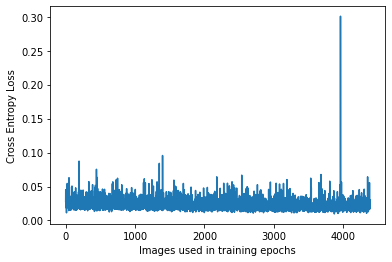

In [ ]:
loss_1d_list = [item for sublist in loss_all_epochs for item in sublist]
loss_list_numpy = []
for i in range(len(loss_1d_list)):
    z = loss_1d_list[i].cpu().detach().numpy()
    loss_list_numpy.append(z)
plt.xlabel("Images used in training epochs")
plt.ylabel("Cross Entropy Loss")
plt.plot(loss_list_numpy)
plt.show()

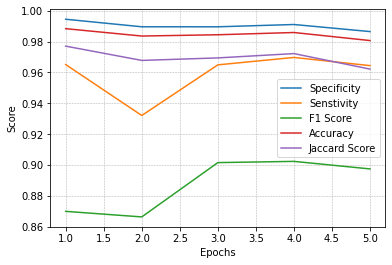

In [ ]:
plt.clf()

x = [i for i in range(1, train_epochs + 1)]

# plot 5 metrics: Specificity, Senstivity, F1 Score, Accuracy, Jaccard Score
plt.plot(x,Specificity_, label='Specificity')
plt.plot(x,Senstivity_, label='Senstivity')
plt.plot(x,F1_, label='F1 Score')
plt.plot(x,acc_, label='Accuracy')
plt.plot(x,js_, label='Jaccard Score')

plt.grid(linestyle = '--', linewidth = 0.5)

plt.xlabel("Epochs")
plt.ylabel("Score")
plt.legend()
plt.show()

0it [00:00, ?it/s]

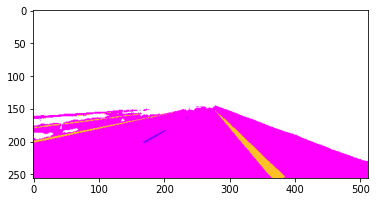

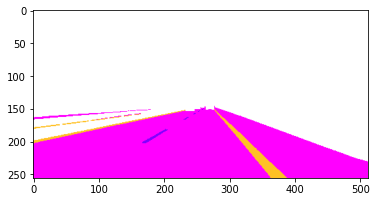

2it [00:02,  1.00s/it]

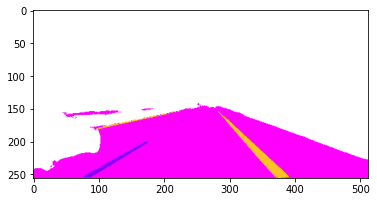

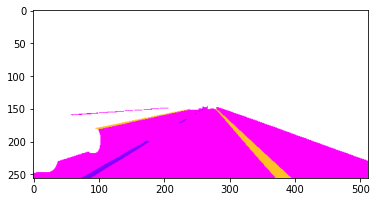

4it [00:04,  1.05it/s]

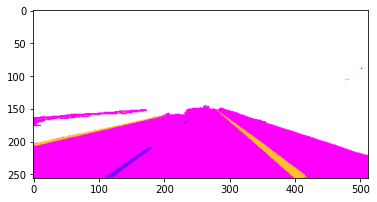

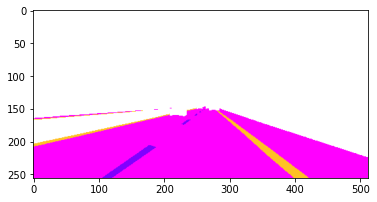

6it [00:05,  1.26it/s]

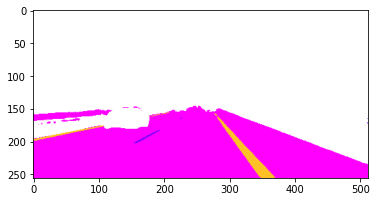

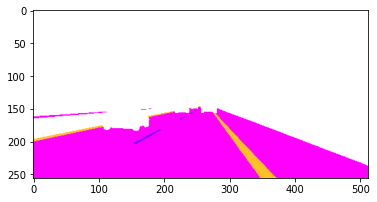

8it [00:07,  1.47it/s]

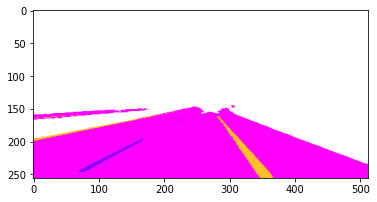

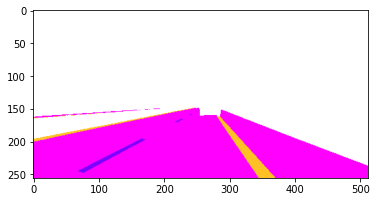

10it [00:08,  1.60it/s]

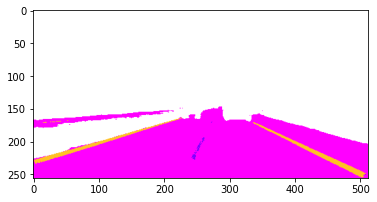

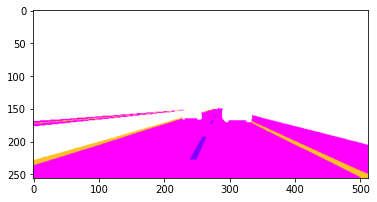

12it [00:09,  1.64it/s]

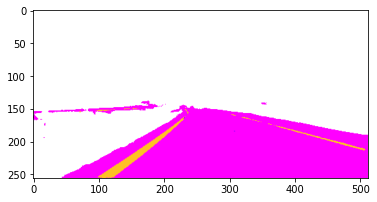

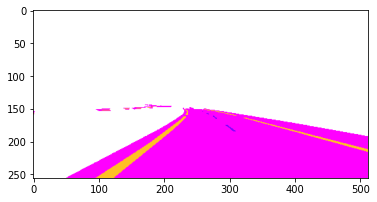

14it [00:10,  1.67it/s]

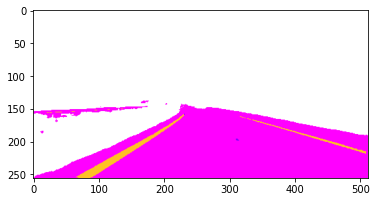

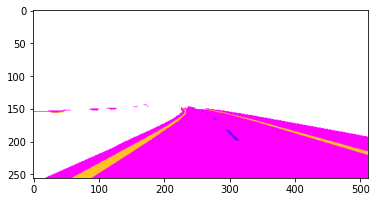

16it [00:12,  1.71it/s]

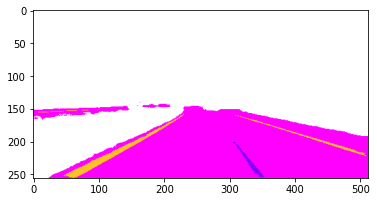

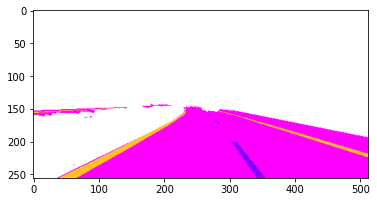

18it [00:13,  1.72it/s]

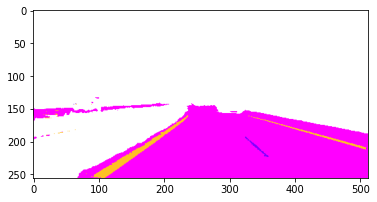

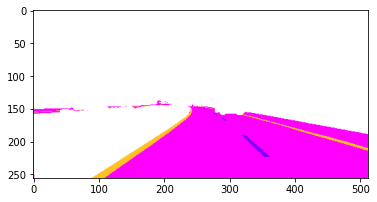

20it [00:14,  1.79it/s]

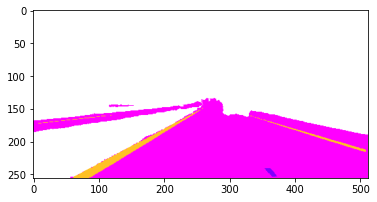

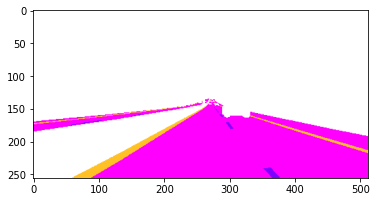

22it [00:15,  1.77it/s]

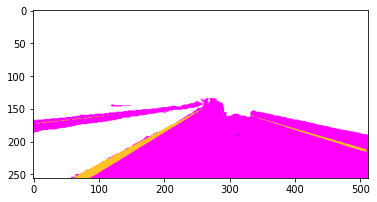

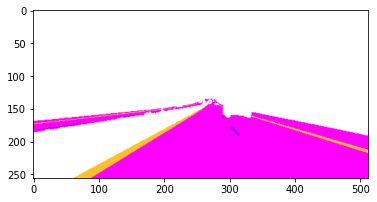

24it [00:17,  1.76it/s]

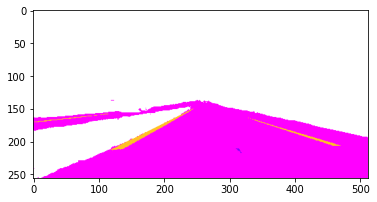

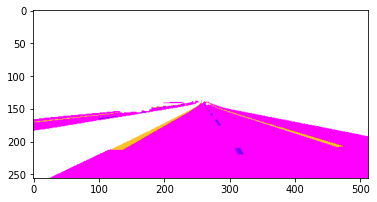

26it [00:18,  1.75it/s]

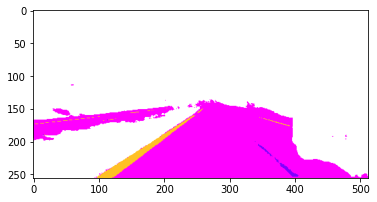

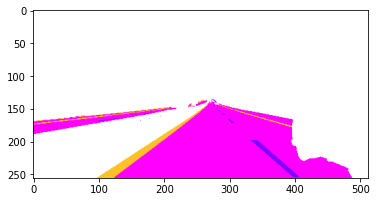

28it [00:19,  1.72it/s]

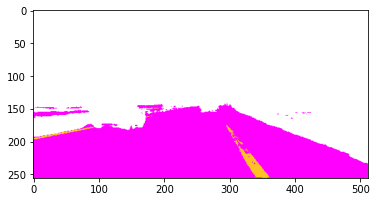

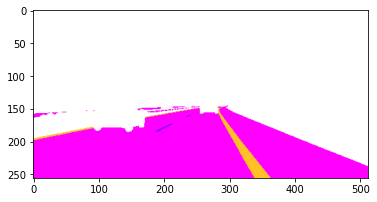

30it [00:21,  1.63it/s]

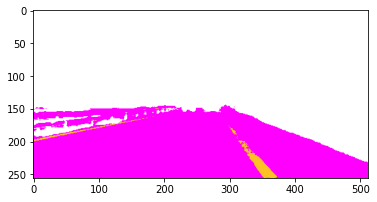

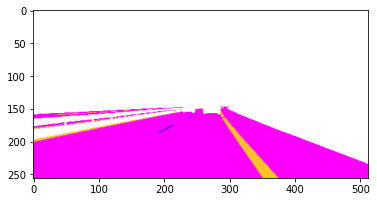

32it [00:22,  1.73it/s]

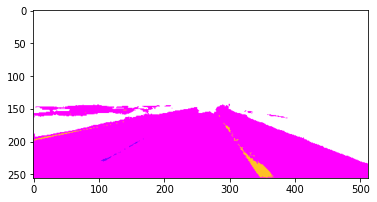

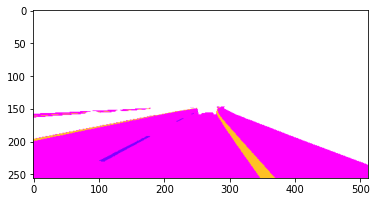

34it [00:23,  1.76it/s]

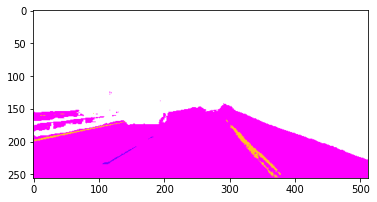

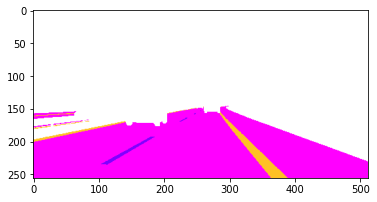

36it [00:24,  1.77it/s]

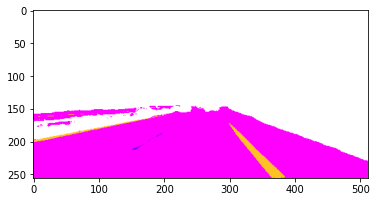

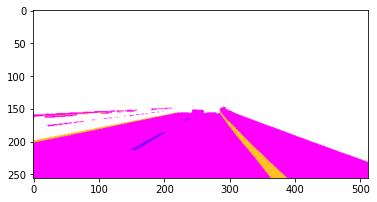

38it [00:25,  1.77it/s]

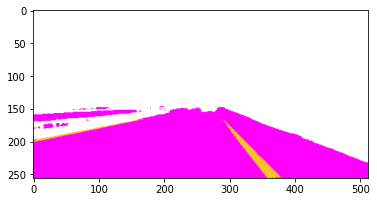

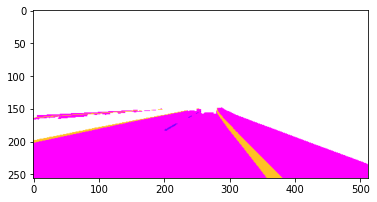

40it [00:27,  1.78it/s]

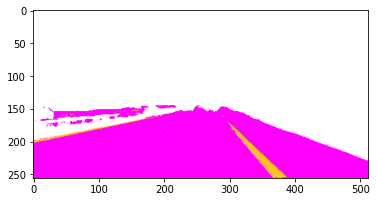

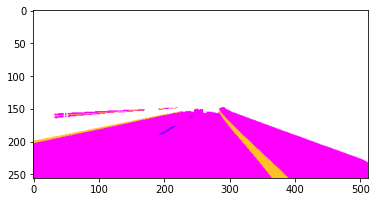

42it [00:28,  1.77it/s]

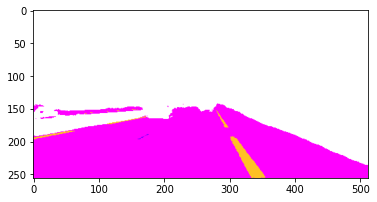

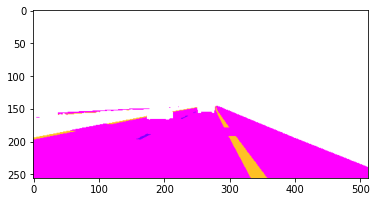

44it [00:29,  1.75it/s]

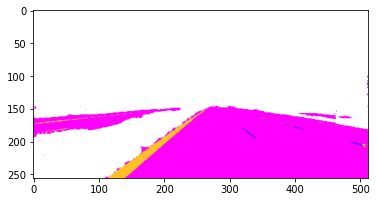

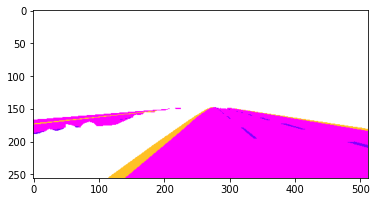

46it [00:30,  1.76it/s]

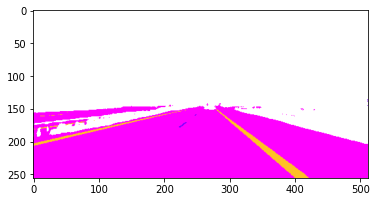

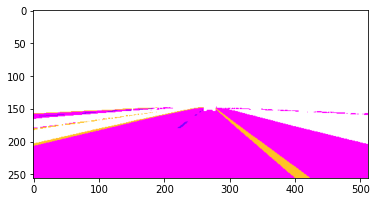

48it [00:32,  1.74it/s]

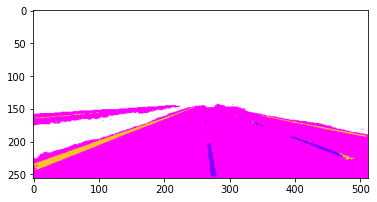

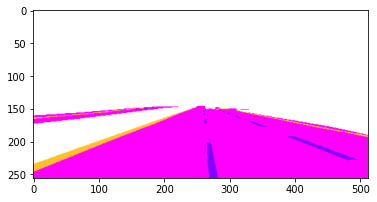

50it [00:33,  1.77it/s]

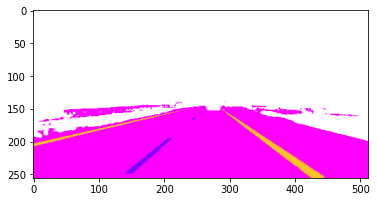

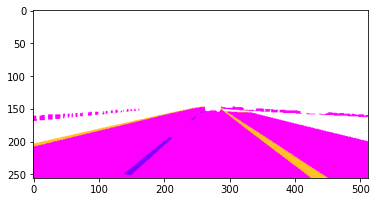

52it [00:34,  1.75it/s]

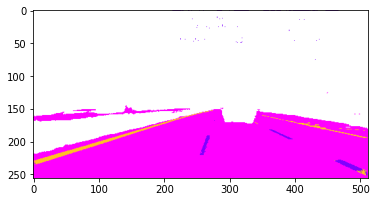

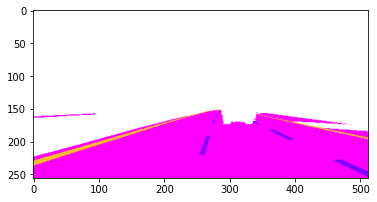

54it [00:35,  1.75it/s]

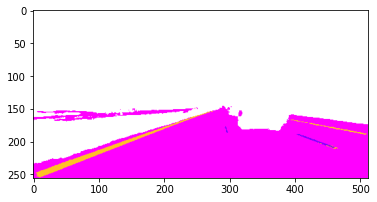

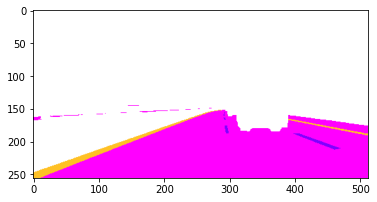

56it [00:37,  1.75it/s]

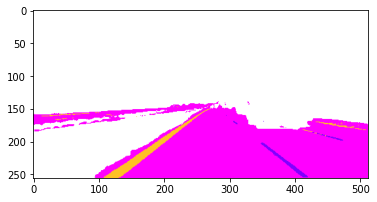

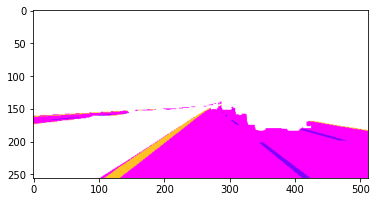

58it [00:38,  1.80it/s]

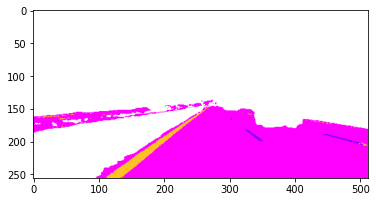

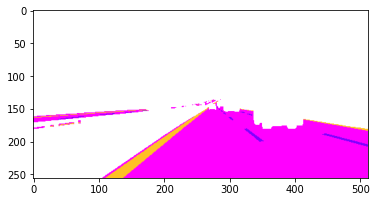

60it [00:39,  1.75it/s]

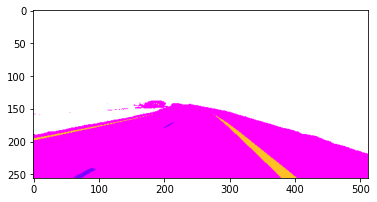

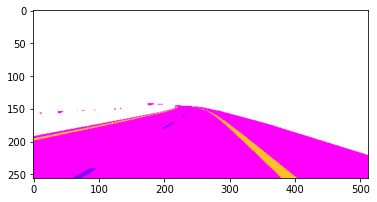

62it [00:40,  1.75it/s]

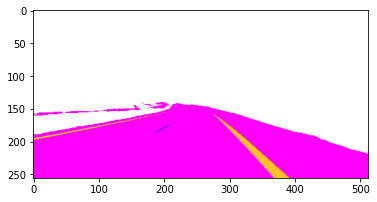

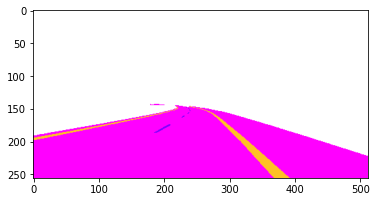

64it [00:41,  1.75it/s]

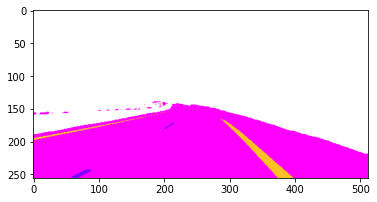

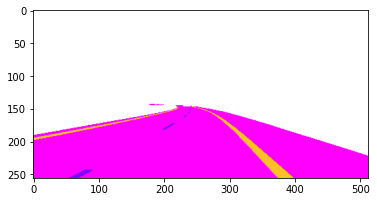

66it [00:43,  1.77it/s]

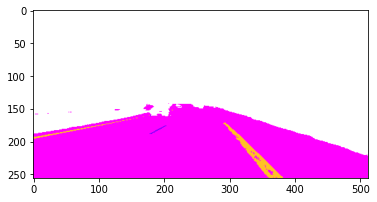

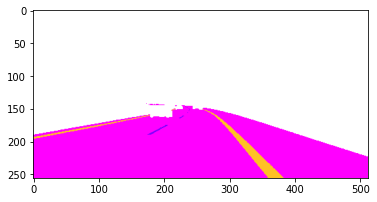

68it [00:44,  1.75it/s]

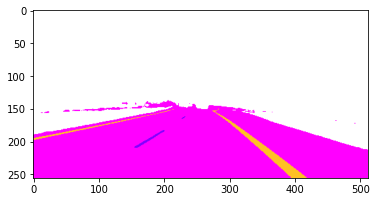

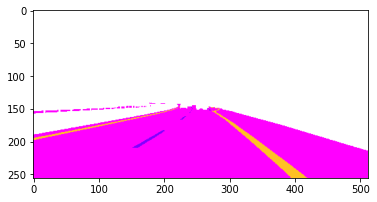

70it [00:45,  1.61it/s]

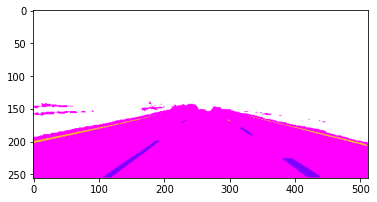

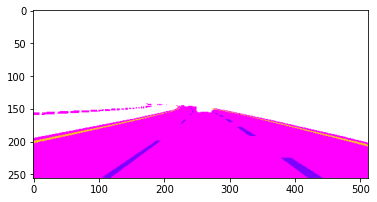

72it [00:47,  1.73it/s]

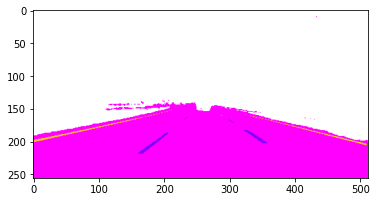

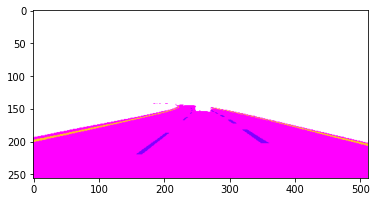

74it [00:48,  1.75it/s]

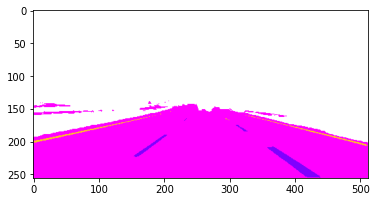

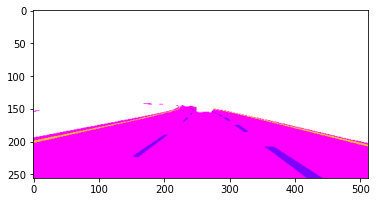

76it [00:50,  1.45it/s]

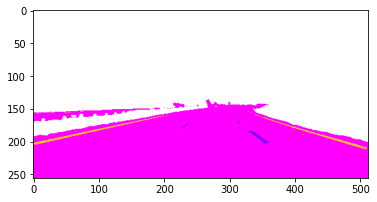

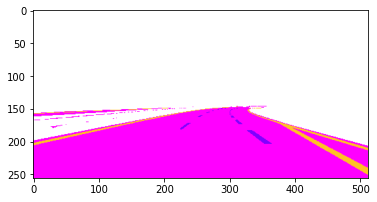

78it [00:51,  1.33it/s]

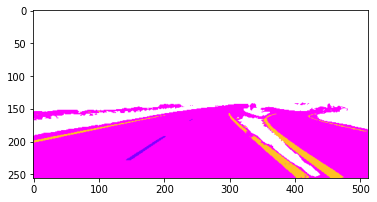

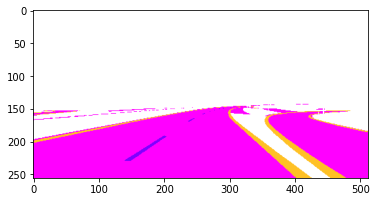

80it [00:53,  1.44it/s]

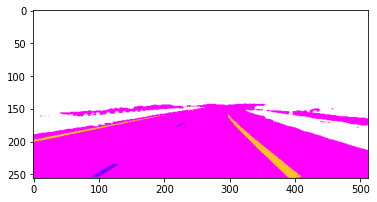

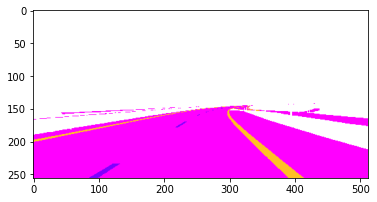

82it [00:54,  1.56it/s]

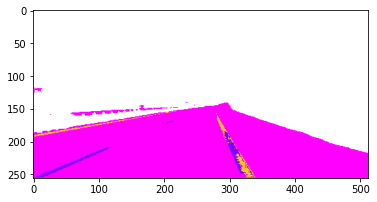

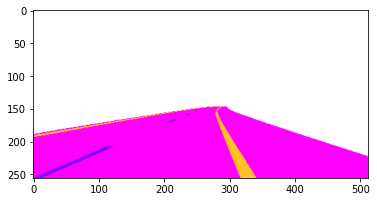

84it [00:55,  1.67it/s]

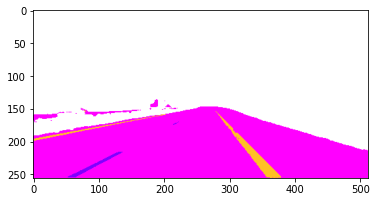

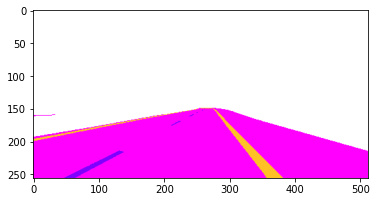

86it [00:57,  1.69it/s]

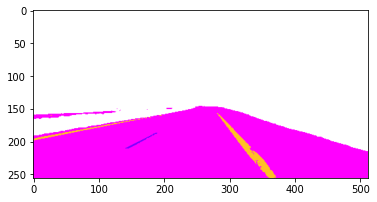

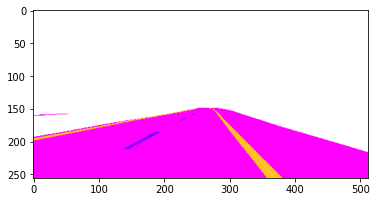

88it [00:58,  1.74it/s]

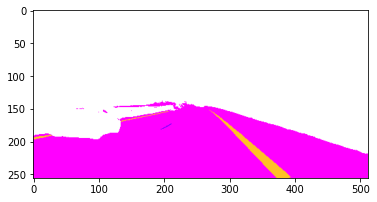

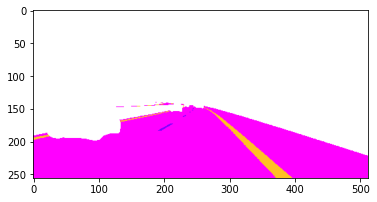

90it [00:59,  1.73it/s]

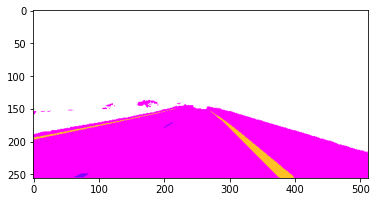

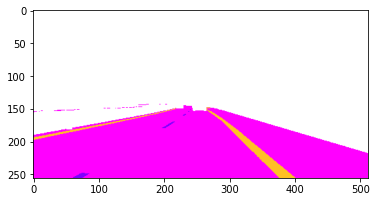

92it [01:00,  1.72it/s]

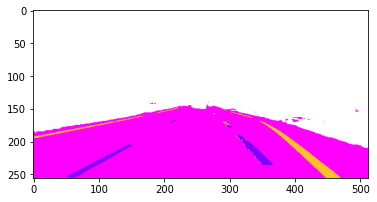

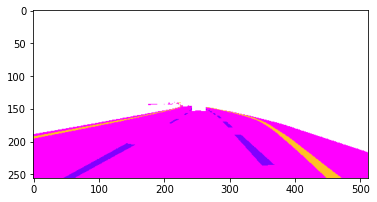

94it [01:01,  1.78it/s]

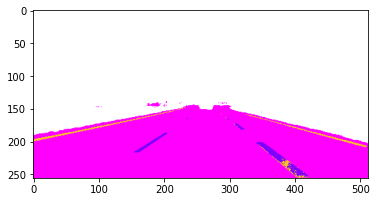

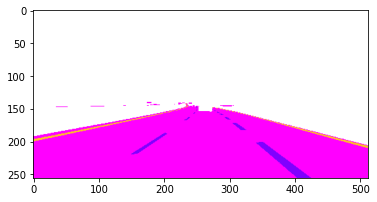

96it [01:03,  1.76it/s]

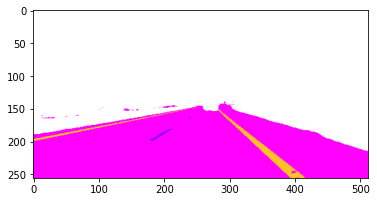

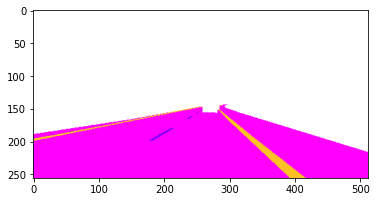

98it [01:04,  1.77it/s]

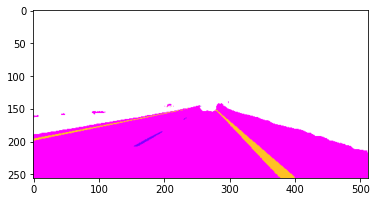

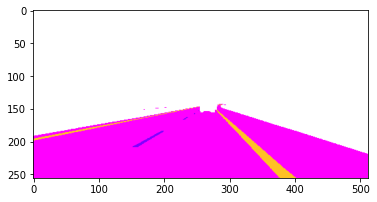

100it [01:05,  1.79it/s]

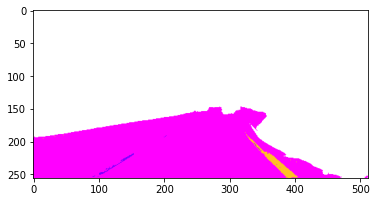

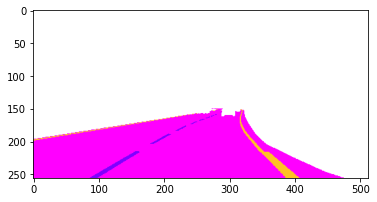

102it [01:06,  1.75it/s]

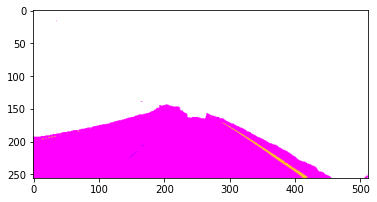

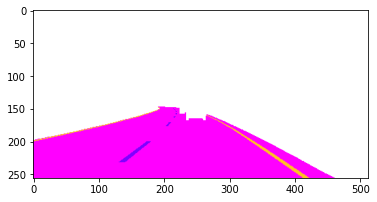

104it [01:08,  1.69it/s]

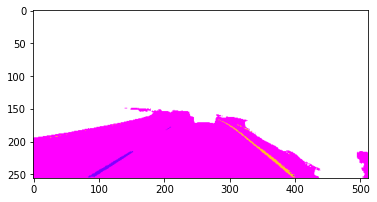

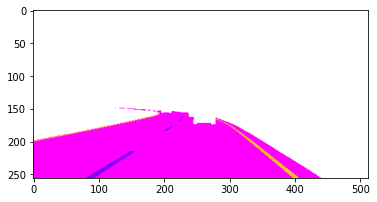

106it [01:09,  1.72it/s]

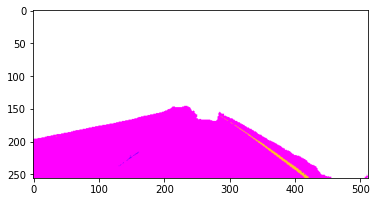

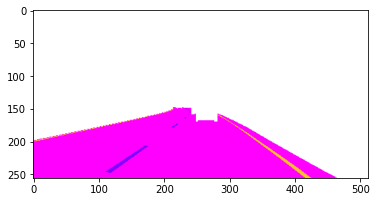

108it [01:10,  1.73it/s]

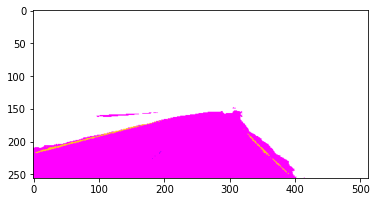

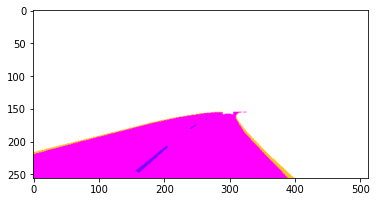

110it [01:11,  1.70it/s]

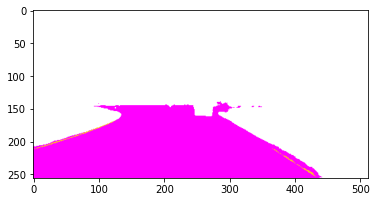

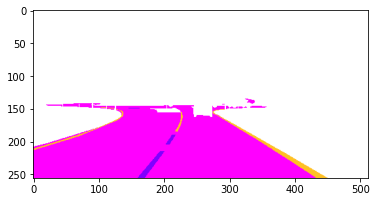

112it [01:13,  1.63it/s]

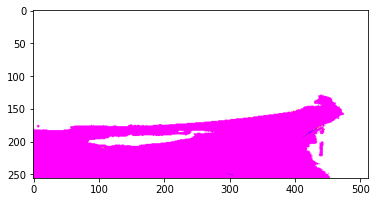

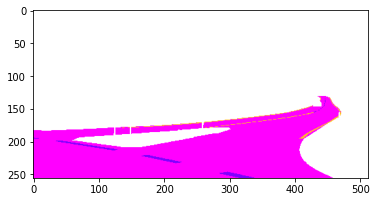

114it [01:14,  1.73it/s]

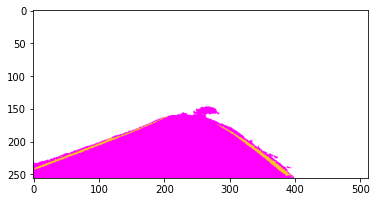

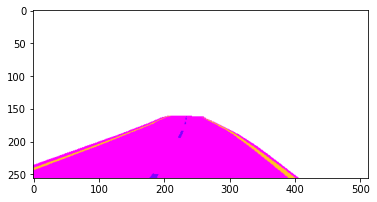

116it [01:15,  1.82it/s]

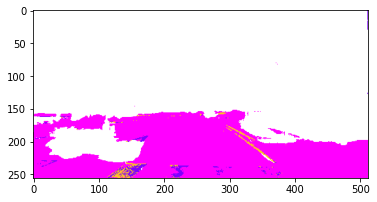

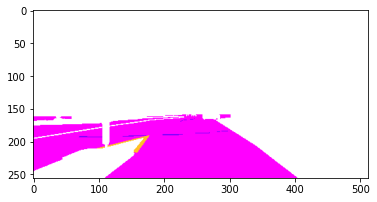

118it [01:16,  1.82it/s]

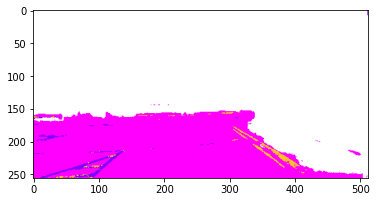

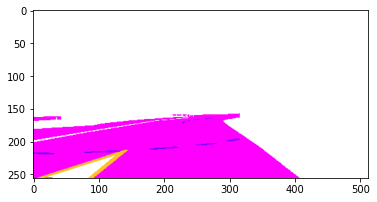

120it [01:18,  1.82it/s]

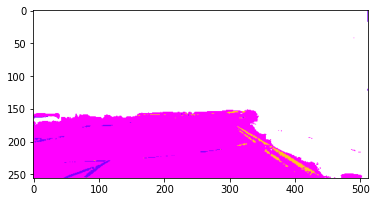

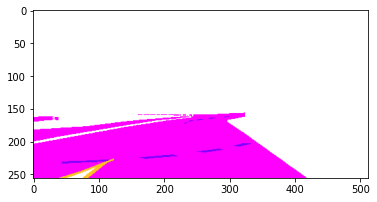

122it [01:19,  1.77it/s]

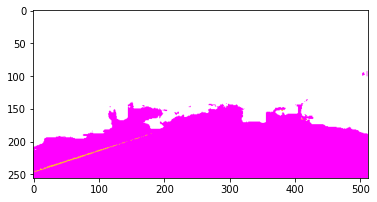

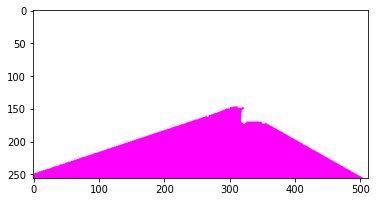

124it [01:20,  1.66it/s]

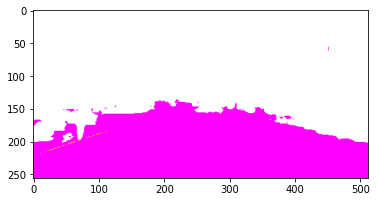

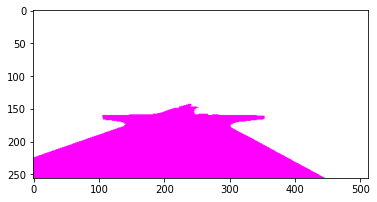

125it [01:21,  1.54it/s]
0it [00:00, ?it/s]

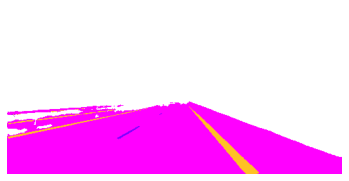

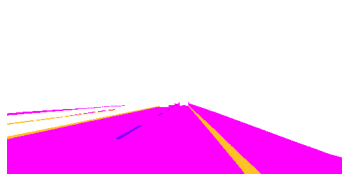

125it [01:42,  1.22it/s]

Different Metrics were:  {'Specificity': 0.9802630471940116, 'Senstivity': 0.9102715321866697, 'F1': 0.8573045078368949, 'Precision': 0.8101627248349812, 'acc': 0.9716754150390625, 'js': 0.94625084435428}


In [ ]:
model.eval()

Specificity_ = []
Senstivity_ = []
F1_ = []
acc_ = []
js_ = []
Precision = []
t = []
    
with torch.no_grad():
    for image_num, (test_images, test_labels) in tqdm(enumerate(test_loader)):

        test_images = test_images.to(device)
        test_labels = test_labels.to(device)
        
        # model prediction
        test_pred = model(test_images)
    
        prediction = test_pred.data.max(1)[1].cpu().numpy()
        ground_truth = test_labels.data.cpu().numpy()

        if image_num % 2 == 0:
            
            # Model Prediction
            decoded_pred = test_data.decode_segmap(prediction[0])
            plt.imshow(decoded_pred)
            plt.show()
            plt.clf()
            
            # Ground Truth
            decode_gt = test_data.decode_segmap(ground_truth[0])
            plt.imshow(decode_gt)
            plt.show()

dummy_list = validate(test_loader, model, epoch_i)   
        
        # Add metrics to empty list above
t.append(t2-t1)
Specificity_.append(dummy_list["Specificity"])
Senstivity_.append(dummy_list["Senstivity"])
F1_.append(dummy_list["F1"])
acc_.append(dummy_list["acc"])
js_.append(dummy_list["js"])
Precision.append(dummy_list["Precision"])     